In [1]:
# <examples/doc_model_two_components.py>
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText, fixed, Text
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]
import inspect

In [2]:
# def get_Latex_Func(func):
#     # Get the source code of the function
#     source_lines = inspect.getsource(func).split('\n')

#     # Find the return statement
#     return_line = [line for line in source_lines if 'return' in line][0]

#     # Extract the expression after 'return'
#     expr = return_line.split('return')[1].strip()
    
#     tatex_func = sympy.latex(sympy.sympify(expr))
#     strg = (
#         "\\begin{align} \n \t f(x) = " + tatex_func + "\n" + "\end{align} \n"
#     )
#     return strg


def get_Latex_Func(func):
    # Get the source code of the function
    source_lines = inspect.getsource(func).split('\n')
    
    # Find the return statement
    return_line = [line for line in source_lines if 'return' in line][0].strip()
    
    # Extract the expression after 'return'
    expr = return_line.split('return')[1].strip()
    
    # Extract variable names from the function's signature
    
    sig = inspect.signature(func)
    param_names = list(sig.parameters.keys())
    
    # Create sympy symbols for all parameters
    symbols = sympy.symbols(' '.join(param_names))
    
    # Create a local dictionary of symbols
    local_dict = dict(zip(param_names, symbols))
    
    # Add numpy and math functions to the local dictionary
    local_dict.update({
        'sqrt': sympy.sqrt,
        'exp': sympy.exp,
        'pi': sympy.pi
    })
    
    # Convert the expression to a SymPy expression
    sympy_expr = sympy.parsing.sympy_parser.parse_expr(
        expr.replace('np.', '').replace('math.', ''), 
        local_dict=local_dict
    )
    
    # Convert to LaTeX
    tatex_func = sympy.latex(sympy_expr)
    
    strg = (
        "\\begin{align} \n \t f(" + ", ".join(param_names) + ") = " + tatex_func + "\n" + "\\end{align} \n"
    )
    return strg




def save_data_to_file(filename='data.pkl'):
    # Dictionary für Parameter-Werte erstellen
    data_dict = {"x":Daten.get_x(),"xerr":Daten.get_xerr(),"y":Daten.get_y(),"yerr":Daten.get_yerr(),"XName":Daten.get_XName(),"YName":Daten.get_YName()}
    # Konvertiere alle Numpy-Arrays im Dictionary in Listen
    # dict_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value 
    #                      for key, value in data_dict.items()}
    # __x = []
    # __y = []
    # __xerr = 0
    # __yerr = 0
    # __XName = "x"
    # __YName = "y"
    # __FileName = "dataset_1"

    # Parameter als JSON-Datei speichern
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Daten wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_data_from_file(filename='params.pkl'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    
    # # Konvertiere Listen zurück in Numpy-Arrays
    # data_dict= {key: np.array(value) if isinstance(value, list) else value
    #                     for key, value in dict_with_arrays.items()}

    # Geladene Werte in die Parameter setzen
    Daten.set_x(data_dict.get("x"))
    Daten.set_xerr(data_dict.get("xerr"))
    Daten.set_y(data_dict.get("y"))
    Daten.set_yerr(data_dict.get("yerr"))
    Daten.set_XName(data_dict.get("XName"))
    Daten.set_YName(data_dict.get("YName"))

    print(f"Daten wurden aus {filename} geladen.")

def finish(x,y,result, string, y_err, yLabel, xLabel, var_func_bool= False):
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \\\\ \n" 
    string_fig += get_Latex_Func(Daten.get_func()) if var_func_bool else ""
    string_fig += table_of_params(result)
    text_file.write(string_fig)
    text_file.close()

def table_of_params(result_of_fit):
    sig_num = 3
    string = "" + (
        "\\begin{table}[ht] \n"
        "\centering \n") +"\caption{" + str(Daten.get_FileName()) +", Fit Parameter Tabelle} \n"  + (
        "\label{tab:my-table}\n"
        "\\begin{tabular}{|l|c|}\n" 
        "\hline\n"
        "Parameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " \\pm "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\end{tabular} \n"
        "\end{table}"
    )
    return string


class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    __FileName = "dataset_1",
    __Version = ""
    __pars = None
    __func = None
    
    def set_func(self, x):
        self.__func = x
        return
    def get_func(self):
        return self.__func

    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName
    
    def get_FileName(self):
        return self.__FileName
    
    def set_FileName(self, x):
        self.__FileName = f"{x}"
        return
    def set_Version(self, x):
        self.__Version = f"{x}"
        return
    def get_Version(self):
        return self.__Version
    
    def get_pars(self):
        return self.__pars
    def set_pars(self,x):
        self.__pars = x
        return

def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:str="0", skip_upper:str="0", x_name:str="x", y_name:str="y", save_bool=False,Save:int=0,Load:int=0,switch_axes:bool=False,show_plot:bool=True):
    data = np.genfromtxt(Datei+".txt", skip_header = int(skip_upper), skip_footer = int(skip_lower))
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)

    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    Daten.set_FileName(Datei)

    if switch_axes:
        temp = [Daten.get_x(), Daten.get_xerr()]
        Daten.set_x(Daten.get_y())
        Daten.set_xerr(Daten.get_yerr())
        Daten.set_y(temp[0])
        Daten.set_yerr(temp[1])
        
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_data_to_file(f'{Daten.get_FileName()}_daten_{Save}.pkl')
    if Load != 0:
        # Aufruf der Funktion zum Laden
        load_data_from_file(f'{Daten.get_FileName()}_daten_{Load}.pkl')

    if show_plot:
        plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
        plt.legend(loc='best')
        plt.ylabel(Daten.get_YName(), fontsize=20)
        plt.xlabel(Daten.get_XName(), fontsize=20)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        if save_bool:
            plt.savefig(Datei + f"_{Load}_Plot.pdf")
            string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Datei + "_Plot.pdf} \n" \
                + "\t\\caption{"+str(Datei)+", Plot_log} \n \t\\label{fig:"+str(Datei)+", Plot_log} \n\end{figure}"
            print(string_fig)

        plt.show()



# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

## Interactive

In [3]:
Daten = Data()

interact(import_Data, Datei="Amps_B05A", x_err_bool = True, y_err_bool = True, x_name = "detector position [\"]", y_name = "detector amplitude [mV]", Daten=fixed(Daten), 
         skip_lower = "0",
         skip_upper = "1",
         save_bool = False,
         switch_axes = False,
         Save=IntText(value=0,description='Daten Speichern:'), Load=IntText(value=0,description='Daten Laden:'),
         
         )# IntText(value=0, step=1)
print()

interactive(children=(Text(value='Amps_B05A', description='Datei'), Checkbox(value=True, description='x_err_bo…

# T Ohm Fit

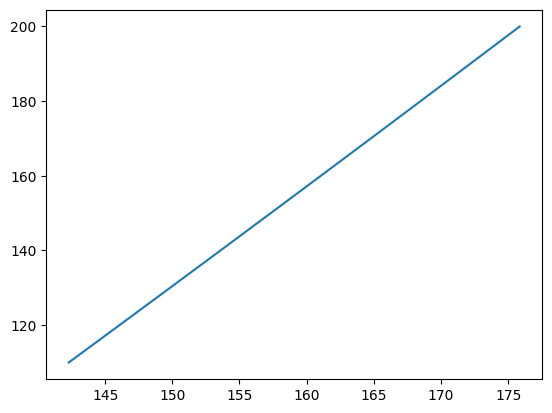

In [5]:
x_ohm = np.array([142.293, 146.068, 149.832, 153.584, 157.325, 161.054, 164.772, 168.478, 172.173, 175.856])
y_ohm = np.array([110, 120, 130, 140, 150, 160, 170, 180, 190, 200])

plt.plot(x_ohm,y_ohm)

In [6]:
from lmfit.models import LinearModel
mod = LinearModel() # Model(model_func_pos) + Model(model_func_neg)

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
slope,1.00000000,None,-inf,inf,True
intercept,0.00000000,None,-inf,inf,True


In [7]:
result = mod.fit(y_ohm, pars, x=x_ohm)
result

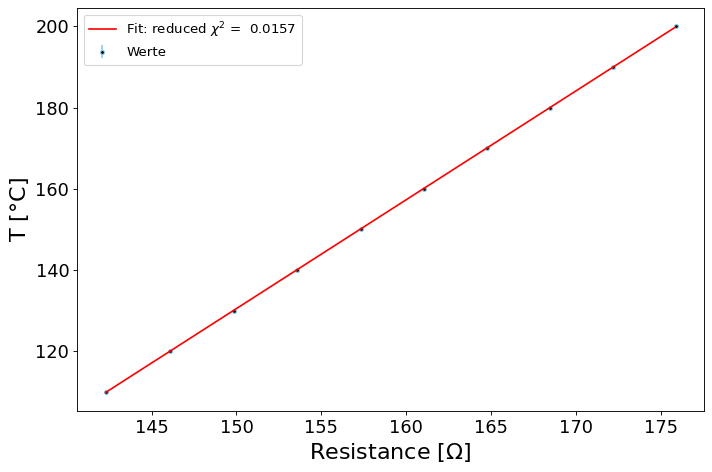

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/T_ohm_Fit.pdf} 
	\caption{T_ohm, Fit} 
 	\label{fig:T_ohm, Fit} 
\end{figure}


In [8]:
finish(x_ohm,y_ohm,result, "T_ohm", 0, r"T [$ \degree $C]", r"Resistance [$ \Omega $]")

## Fit-Funktionen festlegen

In [ ]:
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
    return y


# Beispiel für die h_pos(z, g) mit Fehlerbehandlung
def h_pos(z, g):
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170 + 273.15
    mu_b = 9.2740100783e-24
    cm_umrechnung = 2.54e-3
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T) #* cm_umrechnung
    a = z / z_0
    return 1 / (a**3) * np.exp(-1 / a)


In [ ]:
import numpy as np
import scipy.special
from scipy import signal
from scipy.optimize import minimize

# Your existing function definitions
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
    return y

def h_pos(z, g):
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170 + 273.15
    mu_b = 9.2740100783e-24
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T)
    a = z / z_0
    return 1 / (a**3) * np.exp(-1 / a)

# Convolution function
def convolve_R_h(x, g, a, b, c):
    # Need to handle the convolution carefully due to potential numerical issues
    # First, evaluate R on the same grid as x
    R_values = R(x)
    
    # Evaluate h_pos on the same grid, using g as parameter
    h_values = h_pos(x, g)
    
    # Normalize h_values to preserve the amplitude after convolution
    if np.sum(h_values) != 0:
        h_values = h_values / np.sum(h_values)
    
    # Perform the convolution
    convolution = signal.convolve(R_values, h_values, mode='same')
    
    return convolution*a + b*x + c

# Fitting function
def fit_convolution(x_data, y_data, g_initial=2.0):
    def residual(g):
        y_model = convolve_R_h(x_data, g[0])
        return np.sum((y_model - y_data)**2)
    
    result = minimize(residual, [g_initial], method='Nelder-Mead')
    return result.x[0]  # Return the optimal g value

# Function to plot the results
def plot_fit_results(x_data, y_data, g_fit):
    import matplotlib.pyplot as plt
    
    y_fit = convolve_R_h(x_data, g_fit)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o', label='Data')
    plt.plot(x_data, y_fit, '-', label=f'Fit (g = {g_fit:.4f})')
    plt.plot(x_data, R(x_data), '--', label='Original R(x)')
    plt.plot(x_data, h_pos(x_data, g_fit), '--', label='Original h_pos(x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('Convolution Fit: R(x) * h_pos(x, g)')
    plt.grid(True)
    plt.show()

C:\Users\tlock\AppData\Local\Temp\ipykernel_18728\2963549823.py:19: RuntimeWarning: invalid value encountered in multiply
  y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
c:\Users\tlock\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


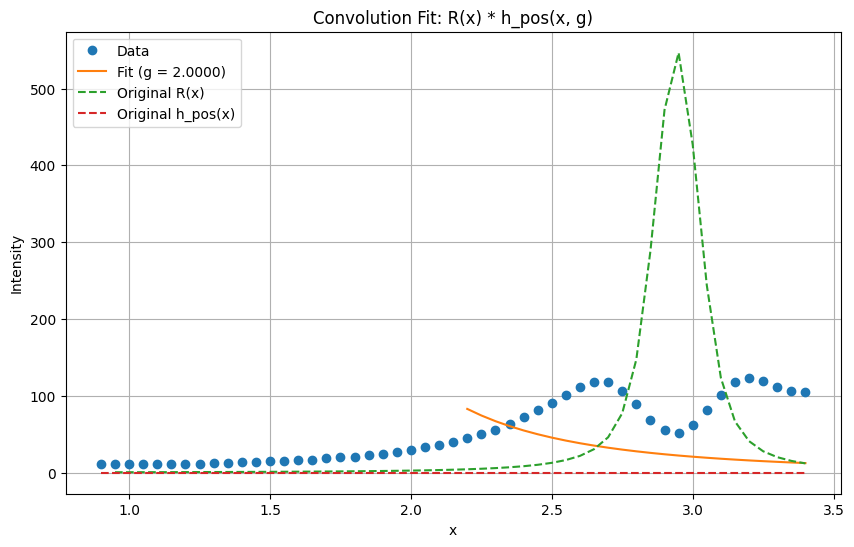

In [17]:
g_opt = fit_convolution(Daten.get_x(), Daten.get_y())
plot_fit_results(Daten.get_x(), Daten.get_y(), g_opt)

In [25]:
import numpy as np
import scipy.special
from scipy import signal
import lmfit
import matplotlib.pyplot as plt

# Your existing function definitions
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2) * np.pi * sigma)
    return y

def h_pos(z, g):
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170 + 273.15
    mu_b = 9.2740100783e-24
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T)
    a = z / z_0
    return 1 / (a**3) * np.exp(-1 / a)

# Convolution function
def convolve_R_h(x, g):
    # Evaluate R on the same grid as x
    R_values = R(x)
    
    # Evaluate h_pos on the same grid, using g as parameter
    try:
        h_values = h_pos(x, g)
        
        # Normalize h_values to preserve the amplitude after convolution
        if np.sum(h_values) != 0:
            h_values = h_values / np.sum(h_values)
        
        # Perform the convolution
        convolution = signal.convolve(R_values, h_values, mode='same')
        return convolution
    except:
        # Handle potential numerical issues
        return np.zeros_like(x)

# Model function for lmfit
def convolution_model(params, x):
    g = params['g'].value
    return convolve_R_h(x, g)

# Residual function for lmfit
def residual(params, x, data):
    model = extended_convolution_model(params, x)
    return model - data

# Function to perform the fit using lmfit
def fit_with_lmfit(x_data, y_data, g_initial=1.0):
    # Create a Parameters object
    params = lmfit.Parameters()
    params.add('g', value=g_initial, min=0.1, max=10)  # Adjust min/max as needed
    
    # Perform the fit
    result = lmfit.minimize(residual, params, args=(x_data, y_data), method='leastsq')
    
    # Print fit report
    print(lmfit.fit_report(result))
    
    return result

# Function to plot the results
def plot_fit_results(x_data, y_data, result):
    g_fit = result.params['g'].value
    g_err = result.params['g'].stderr
    
    y_fit = convolution_model(result.params, x_data)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o', label='Data')
    plt.plot(x_data, y_fit, '-', label=f'Fit (g = {g_fit:.4f} ± {g_err:.4f})')
    plt.plot(x_data, R(x_data), '--', label='Original R(x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('Convolution Fit: R(x) * h_pos(x, g)')
    plt.grid(True)
    plt.show()
    
    # Return the optimal g value and its uncertainty
    return g_fit, g_err


def extended_convolution_model(params, x):
    params.add('g', value= 2, min=0.1, max=10)
    params.add('amplitude', value=1.0, min=0.1)
    params.add('background', value=0.0, vary=True)
    g = params['g'].value
    amplitude = params['amplitude'].value
    background = params['background'].value
    
    convolution = convolve_R_h(x, g)
    return amplitude * convolution + background

In [26]:
g_opt = fit_with_lmfit(Daten.get_x(), Daten.get_y())
plot_fit_results(Daten.get_x(), Daten.get_y(), g_opt)

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

## FFT

In [27]:
import numpy as np
import scipy.special
from scipy.fft import fft, ifft, fftshift, ifftshift
import lmfit
import matplotlib.pyplot as plt

# Your existing function definitions
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2) * np.pi * sigma)
    return y

def h_pos(z, g):
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170 + 273.15
    mu_b = 9.2740100783e-24
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T)
    a = z / z_0
    return 1 / (a**3) * np.exp(-1 / a)

# Convolution using FFT
def convolve_fft(x, g):
    # Evaluate R and h_pos on the x grid
    R_values = R(x)
    try:
        h_values = h_pos(x, g)
        
        # Normalize h_values to preserve the amplitude after convolution
        if np.sum(h_values) != 0:
            h_values = h_values / np.sum(h_values)
        
        # Compute FFTs
        R_fft = fft(R_values)
        h_fft = fft(h_values)
        
        # Multiply in frequency domain
        conv_fft = R_fft * h_fft
        
        # Inverse transform to get convolution
        convolution = np.real(ifft(conv_fft))
        
        return convolution
    except:
        # Handle potential numerical issues
        return np.zeros_like(x)

# Model function for lmfit
def convolution_model_fft(params, x):
    g = params['g'].value
    return convolve_fft(x, g)

# Residual function for lmfit
def residual_fft(params, x, data):
    model = convolution_model_fft(params, x)
    return model - data

# Function to perform the fit using lmfit with FFT convolution
def fit_with_lmfit_fft(x_data, y_data, g_initial=1.0):
    # Create a Parameters object
    params = lmfit.Parameters()
    params.add('g', value=g_initial, min=0.1, max=10)  # Adjust min/max as needed
    
    # Perform the fit
    result = lmfit.minimize(residual_fft, params, args=(x_data, y_data), method='leastsq')
    
    # Print fit report
    print(lmfit.fit_report(result))
    
    return result

# Function to plot the results
def plot_fit_results_fft(x_data, y_data, result):
    g_fit = result.params['g'].value
    g_err = result.params['g'].stderr if result.params['g'].stderr is not None else 0
    
    y_fit = convolution_model_fft(result.params, x_data)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o', label='Data')
    plt.plot(x_data, y_fit, '-', label=f'Fit (g = {g_fit:.4f} ± {g_err:.4f})')
    plt.plot(x_data, R(x_data), '--', label='Original R(x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('FFT Convolution Fit: R(x) * h_pos(x, g)')
    plt.grid(True)
    plt.show()
    
    # Return the optimal g value and its uncertainty
    return g_fit, g_err

In [29]:
import numpy as np
import scipy.special
from scipy.fft import fft, ifft
import lmfit
import matplotlib.pyplot as plt

# Your existing function definitions
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2) * np.pi * sigma)
    return y

def h_pos(z, g):
    """Modified h_pos function with safeguards against NaN values."""
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T = 170 + 273.15
    mu_b = 9.2740100783e-24
    
    # Calculate z_0 with protection against division by zero
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T)
    
    # Protect against z_0 being zero or very small
    if np.abs(z_0) < 1e-10:
        return np.zeros_like(z)
    
    # Calculate a with protection
    a = z / z_0
    
    # Handle cases where a might lead to NaN
    mask = (np.abs(a) > 1e-10)  # Avoid very small values of a
    result = np.zeros_like(z, dtype=float)
    
    # Only calculate for valid a values
    valid_a = a[mask]
    result[mask] = 1 / (valid_a**3) * np.exp(-1 / valid_a)
    
    # Replace any NaN or inf values with zeros
    result = np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)
    
    return result

# Convolution using FFT with safeguards
def convolve_fft_safe(x, g):
    # Evaluate R and h_pos on the x grid
    R_values = R(x)
    h_values = h_pos(x, g)
    
    # Replace any NaN values
    R_values = np.nan_to_num(R_values, nan=0.0)
    h_values = np.nan_to_num(h_values, nan=0.0)
    
    # Normalize h_values to preserve the amplitude after convolution
    h_sum = np.sum(h_values)
    if h_sum > 1e-10:  # Avoid division by very small numbers
        h_values = h_values / h_sum
    else:
        # If h_sum is too small, use a default distribution
        h_values = np.zeros_like(x)
        mid_point = len(x) // 2
        h_values[mid_point] = 1.0  # Delta function at center
    
    # Zero-padding to avoid circular convolution effects
    n = len(x)
    R_padded = np.zeros(2*n)
    h_padded = np.zeros(2*n)
    R_padded[:n] = R_values
    h_padded[:n] = h_values
    
    # FFT convolution
    R_fft = fft(R_padded)
    h_fft = fft(h_padded)
    conv_fft = R_fft * h_fft
    convolution_padded = np.real(ifft(conv_fft))
    
    # Take only the relevant part and ensure no NaN values
    result = convolution_padded[:n]
    result = np.nan_to_num(result, nan=0.0)
    
    return result

# Model function for lmfit
def convolution_model_fft_safe(params, x):
    g = params['g'].value
    return convolve_fft_safe(x, g)

# Residual function for lmfit
def residual_fft_safe(params, x, data):
    model = convolution_model_fft_safe(params, x)
    return model - data

# Function to perform the fit using lmfit with FFT convolution
def fit_with_lmfit_fft_safe(x_data, y_data, g_initial=1.0):
    # Create a Parameters object
    params = lmfit.Parameters()
    params.add('g', value=g_initial, min=0.1, max=10)  # Adjust min/max as needed
    
    # Perform the fit with robust method
    result = lmfit.minimize(residual_fft_safe, params, args=(x_data, y_data), 
                          method='least_squares')  # Using least_squares for robustness
    
    # Print fit report
    print(lmfit.fit_report(result))
    
    return result

# Function to plot the results
def plot_fit_results_fft_safe(x_data, y_data, result):
    g_fit = result.params['g'].value
    g_err = result.params['g'].stderr if result.params['g'].stderr is not None else 0
    
    y_fit = convolution_model_fft_safe(result.params, x_data)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o', label='Data')
    plt.plot(x_data, y_fit, '-', label=f'Fit (g = {g_fit:.4f} ± {g_err:.4f})')
    plt.plot(x_data, R(x_data), '--', label='Original R(x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('FFT Convolution Fit: R(x) * h_pos(x, g)')
    plt.grid(True)
    plt.show()
    
    # Return the optimal g value and its uncertainty
    return g_fit, g_err

In [33]:
# Test the R function
x_test = np.linspace(1, 3.2, 100)
r_values = R(x_test)
print("R function NaN check:", np.isnan(r_values).any())

# Test the h_pos function with a few g values
for g_test in [0.5, 1.0, 2.0, 5.0]:
    h_values = h_pos(x_test, g_test)
    print(f"h_pos function with g={g_test}, NaN check:", np.isnan(h_values).any())

R function NaN check: False
h_pos function with g=0.5, NaN check: False
h_pos function with g=1.0, NaN check: False
h_pos function with g=2.0, NaN check: False
h_pos function with g=5.0, NaN check: False


In [34]:
fit_result = fit_with_lmfit_fft_safe(Daten.get_x(), Daten.get_y(), g_initial=2.0)

# Plot the results and get the optimal g value
g_optimal, g_uncertainty = plot_fit_results_fft_safe(Daten.get_x(), Daten.get_y(), fit_result)
print(f"Optimal g value: {g_optimal:.6f} ± {g_uncertainty:.6f}")

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [37]:
import numpy as np
import scipy.special
from scipy.fft import fft, ifft
import lmfit
import matplotlib.pyplot as plt

# Your existing function definitions
def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T_ohm(Ohm):
    return 2.68146897 * Ohm -271.738357

def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2) * np.pi * sigma)
    return y

def h_pos(z, g):
    """Modified h_pos function with safeguards against NaN values."""
    I = 0.5  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    Ohm = 166
    T = T_ohm(Ohm) + 273.15
    mu_b = 9.2740100783e-24
    
    # Calculate z_0 with protection against division by zero
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T)
    
    # Protect against z_0 being zero or very small
    if np.abs(z_0) < 1e-10:
        return np.zeros_like(z)
    
    # Calculate a with protection
    a = z / z_0
    
    # Handle cases where a might lead to NaN
    mask = (np.abs(a) > 1e-10)  # Avoid very small values of a
    result = np.zeros_like(z, dtype=float)
    
    # Only calculate for valid a values
    valid_a = a[mask]
    result[mask] = 1 / (valid_a**3) * np.exp(-1 / valid_a)
    
    # Replace any NaN or inf values with zeros
    result = np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)
    
    return result

# Convolution using FFT with safeguards
def convolve_fft_safe(x, g):
    # Evaluate R and h_pos on the x grid
    R_values = R(x)
    h_values = h_pos(x, g)
    
    # Replace any NaN values
    R_values = np.nan_to_num(R_values, nan=0.0)
    h_values = np.nan_to_num(h_values, nan=0.0)
    
    # Normalize h_values to preserve the amplitude after convolution
    h_sum = np.sum(h_values)
    if h_sum > 1e-10:  # Avoid division by very small numbers
        h_values = h_values / h_sum
    else:
        # If h_sum is too small, use a default distribution
        h_values = np.zeros_like(x)
        mid_point = len(x) // 2
        h_values[mid_point] = 1.0  # Delta function at center
    
    # Zero-padding to avoid circular convolution effects
    n = len(x)
    R_padded = np.zeros(2*n)
    h_padded = np.zeros(2*n)
    R_padded[:n] = R_values
    h_padded[:n] = h_values
    
    # FFT convolution
    R_fft = fft(R_padded)
    h_fft = fft(h_padded)
    conv_fft = R_fft * h_fft
    convolution_padded = np.real(ifft(conv_fft))
    
    # Take only the relevant part and ensure no NaN values
    result = convolution_padded[:n]
    result = np.nan_to_num(result, nan=0.0)
    
    return result

# Extended model function with scale and offset parameters
def extended_model(params, x):
    g = params['g'].value
    scale = params['scale'].value
    offset = params['offset'].value
    
    conv = convolve_fft_safe(x, g)
    return scale * conv + offset

# Residual function for the extended model
def extended_residual(params, x, data):
    model = extended_model(params, x)
    return model - data

# Function to perform the fit using the extended model
def fit_with_extended_model(x_data, y_data, g_initial=1.0):
    # Create a Parameters object with extended parameters
    params = lmfit.Parameters()
    params.add('g', value=g_initial, min=0.1, max=10)
    params.add('scale', value=1.0, min=0.1)
    params.add('offset', value=0.0)
    
    # Perform the fit with robust method
    result = lmfit.minimize(extended_residual, params, args=(x_data, y_data), 
                          method='least_squares')  # Using least_squares for robustness
    
    # Print fit report
    print(lmfit.fit_report(result))
    
    return result

# Function to plot the results with the extended model
def plot_extended_model_results(x_data, y_data, result):
    g_fit = result.params['g'].value
    g_err = result.params['g'].stderr if result.params['g'].stderr is not None else 0
    scale = result.params['scale'].value
    offset = result.params['offset'].value
    
    # Calculate fitted curve
    y_fit = extended_model(result.params, x_data)
    
    # Calculate the convolution without scaling for comparison
    conv_only = convolve_fft_safe(x_data, g_fit)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o', label='Data')
    plt.plot(x_data, y_fit, '-', label=f'Fit: g={g_fit:.4f}±{g_err:.4f}, scale={scale:.4f}, offset={offset:.4f}')
    plt.plot(x_data, conv_only, '--', label='Convolution (before scaling)')
    plt.plot(x_data, R(x_data), ':', label='Original R(x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('Extended Model: scale * [R(x) * h_pos(x, g)] + offset')
    plt.grid(True)
    plt.show()
    
    # Return the optimal parameters
    return {
        'g': g_fit,
        'g_error': g_err,
        'scale': scale,
        'offset': offset
    }

# Example usage
def run_fit_with_data(x_data, y_data):
    """Utility function to run the fitting process with user data"""
    # Initial diagnostics
    print("Input data shape:", x_data.shape, y_data.shape)
    print("NaN check in x_data:", np.isnan(x_data).any())
    print("NaN check in y_data:", np.isnan(y_data).any())
    
    # Try different initial g values to avoid local minima
    initial_g_values = [0.5, 1.0, 2.0, 5.0]
    best_result = None
    best_chisqr = float('inf')
    
    for g_init in initial_g_values:
        try:
            print(f"\nTrying fit with initial g = {g_init}")
            result = fit_with_extended_model(x_data, y_data, g_initial=g_init)
            
            if result.chisqr < best_chisqr:
                best_result = result
                best_chisqr = result.chisqr
                print(f"New best fit found with g = {g_init}")
        except Exception as e:
            print(f"Fit with g = {g_init} failed: {str(e)}")
    
    if best_result is None:
        print("All fitting attempts failed. Please check your data for issues.")
        return None
    
    # Plot the best result
    print("\nBest fit parameters:")
    params = plot_extended_model_results(x_data, y_data, best_result)
    return params

In [38]:
run_fit_with_data(Daten.get_x(), Daten.get_y())

Input data shape: (51,) (51,)
NaN check in x_data: False
NaN check in y_data: False

Trying fit with initial g = 0.5
Fit with g = 0.5 failed: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

Trying fit with initial g = 1.0
Fit with g = 1.0 failed: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

Trying fit with initial g = 2.0
Fit with g = 2.0 failed: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more informat

In [28]:
import numpy as np
import scipy.special
from scipy.integrate import quad
from sympy import symbols, lambdify


def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    try:
        # z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
        # y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
        z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
        y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
        
        # Fehlerbehandlung: Wenn der Wert zu groß oder NaN ist, setze ihn auf 0
        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            return np.zeros_like(y)
        return y
    except Exception as e:
        print(f"Fehler in R(x): {e}")
        return np.zeros_like(x)  # Rückgabe von 0 bei Fehlern

# Beispiel für die h_pos(z, g) mit Fehlerbehandlung
def h_pos(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T) #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
    
def h_neg(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = -1 / 2 * mu_b * dB(I)* g * d1 * (d2 + d1 / 2) / (k * T) #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_neg(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
     
# Integrand mit Korrektur
def integrand(a, b, g):
    return R(b - a) * h_pos(a, g)

def integrand_neg(a, b, g):
    return R(b - a) * h_neg(a, g)

# Lambda-Funktion für das Integral
# integral = lambda b, g: quad(integrand, -np.inf, np.inf, args=(b, g))[0]
# integral_neg = lambda b_, g_: quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0]

def integral_pos(x, g): 
    b = x
    return quad(integrand, -np.inf, np.inf, args=(b, g))[0]

def integral_neg(x, g_):
    b_ = x
    return quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0]

# Lambda-Funktion für das Integral
# integral = np.vectorize(lambda b, g: quad(integrand, -np.inf, np.inf, args=(b, g))[0])(x_values)
# integral_neg = np.vectorize(lambda b_, g_: quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0])(x_values)
def model_func_pos(x:np.ndarray, g):
    return np.array([integral_pos(xi, g) for xi in x])
def model_func_neg(x:np.ndarray, g_):
    return np.array([integral_neg(xi, g_) for xi in x])

def model_func(x:np.ndarray, g):
    return np.array([integral_pos(xi, g) for xi in x]) + np.array([integral_neg(xi, g) for xi in x])


In [ ]:
import numpy as np
import scipy.special
from scipy.integrate import quad
from sympy import symbols, lambdify


def B(I):
    return 0.62941*I+0.14196*I**2-0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm -271.738357

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    try:
        # z = (x-result.params["center"].value+result.params["gamma"].value * 1j)/(np.sqrt(2)*result.params["sigma"].value)
        # y = (result.params["amplitude"].value*np.real(np.exp(-z**2)*scipy.special.erfc(-1j*z)))/(np.sqrt(2*np.pi)*result.params["sigma"].value)
        z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
        y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
        
        # Fehlerbehandlung: Wenn der Wert zu groß oder NaN ist, setze ihn auf 0
        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            return np.zeros_like(y)
        return y
    except Exception as e:
        print(f"Fehler in R(x): {e}")
        return np.zeros_like(x)  # Rückgabe von 0 bei Fehlern

# Beispiel für die h_pos(z, g) mit Fehlerbehandlung
def h_pos(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T) #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
    
def h_neg(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T = 170 + 273.15
        mu_b = 9.2740100783e-24
        cm_umrechnung = 2.54e-3
        z_0 = -1 / 2 * mu_b * dB(I)* g * d1 * (d2 + d1 / 2) / (k * T) #* cm_umrechnung
        
        if z_0 == 0:
            return 0  # Verhindern, dass Division durch 0 auftritt
        
        a = z / z_0
        
        # Wenn a zu groß wird, kann es numerische Probleme geben
        if np.abs(a) > 1e6:
            return 0  # Rückgabe von 0, wenn a zu groß wird

        return 1 / (a**3) * np.exp(-1 / a)
    except Exception as e:
        print(f"Fehler in h_neg(z, g): {e}")
        return 0  # Rückgabe von 0 bei Fehlern
     
# Integrand mit Korrektur
def integrand(a, b, g):
    return R(b - a) * h_pos(a, g)

def integrand_neg(a, b, g):
    return R(b - a) * h_neg(a, g)

# Lambda-Funktion für das Integral
# integral = lambda b, g: quad(integrand, -np.inf, np.inf, args=(b, g))[0]
# integral_neg = lambda b_, g_: quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0]

def integral_pos(x, g): 
    b = x
    return quad(integrand, -np.inf, np.inf, args=(b, g))[0]

def integral_neg(x, g_):
    b_ = x
    return quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0]

# Lambda-Funktion für das Integral
# integral = np.vectorize(lambda b, g: quad(integrand, -np.inf, np.inf, args=(b, g))[0])(x_values)
# integral_neg = np.vectorize(lambda b_, g_: quad(integrand_neg, -np.inf, np.inf, args=(b_, g_))[0])(x_values)
def model_func_pos(x:np.ndarray, g):
    return np.array([integral_pos(xi, g) for xi in x])
def model_func_neg(x:np.ndarray, g_):
    return np.array([integral_neg(xi, g_) for xi in x])

def model_func(x:np.ndarray, g):
    return np.array([integral_pos(xi, g) for xi in x]) + np.array([integral_neg(xi, g) for xi in x])


# Claude optimisation

In [43]:
import numpy as np
import scipy.special
from scipy.integrate import quad
from sympy import symbols, lambdify

def B(I):
    return 0.62941*I + 0.14196*I**2 - 0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm - 271.738357

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x: np.ndarray):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    try:
        z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
        y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
        
        # Verbesserte Fehlerbehandlung: Wenn der Wert zu groß oder NaN ist, setze ihn auf 0
        if isinstance(y, np.ndarray):
            mask = np.isnan(y) | np.isinf(y)
            y[mask] = 0
            return y
        else:
            if np.isnan(y) or np.isinf(y):
                return 0
            return y
    except Exception as e:
        print(f"Fehler in R(x): {e}")
        if isinstance(x, np.ndarray):
            return np.zeros_like(x)
        else:
            return 0

# Verbesserte h_pos-Funktion mit besserer numerischer Stabilität
def h_pos(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T_val = T(170)  # Verwendung der T-Funktion statt direktem Wert
        mu_b = 9.2740100783e-24
        
        # Berechnung von z_0 mit Prüfung auf sehr kleine Werte
        z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
        
        # Sicherheitsprüfung für z_0
        if abs(z_0) < 1e-10:
            return 0
        
        a = z / z_0
        
        # Verbesserte Berechnung für numerische Stabilität
        # Sehr kleine oder große a-Werte abfangen
        if abs(a) < 1e-6 or abs(a) > 1e6:
            return 0
            
        # Berechnung mit numerisch stabilerem Ansatz
        # Statt 1/(a³) * exp(-1/a) direkt zu berechnen
        # Logarithmische Form für bessere numerische Stabilität
        log_result = -3 * np.log(abs(a)) - 1/a
        
        # Vermeiden von Überläufen
        if log_result < -700:  # Ungefährer Grenzwert für exp in Python
            return 0
            
        return np.exp(log_result)
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        return 0
    
# Verbesserte h_neg-Funktion mit besserer numerischer Stabilität
def h_neg(z, g):
    try:
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T_val = T(170)  # Verwendung der T-Funktion statt direktem Wert
        mu_b = 9.2740100783e-24
        
        # Berechnung von z_0 mit Prüfung auf sehr kleine Werte
        z_0 = -1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
        
        # Sicherheitsprüfung für z_0
        if abs(z_0) < 1e-10:
            return 0
        
        a = z / z_0
        
        # Verbesserte Berechnung für numerische Stabilität
        if abs(a) < 1e-6 or abs(a) > 1e6:
            return 0
            
        # Logarithmische Form für bessere numerische Stabilität
        log_result = -3 * np.log(abs(a)) - 1/a
        
        # Vermeiden von Überläufen
        if log_result < -700:
            return 0
            
        return np.exp(log_result)
    except Exception as e:
        print(f"Fehler in h_neg(z, g): {e}")
        return 0

# Verbesserte Integranden
def integrand(a, b, g):
    result = R(b - a) * h_pos(a, g)
    return 0 if np.isnan(result) or np.isinf(result) else result

def integrand_neg(a, b, g):
    result = R(b - a) * h_neg(a, g)
    return 0 if np.isnan(result) or np.isinf(result) else result

# Verbesserte Integration mit adaptiver Berechnung der Integrationsgrenzen
def integral_pos(x, g):
    # Adaptive Integrationsgrenze basierend auf g und x
    # Finde den Bereich, wo der Integrand signifikant ist
    
    # Beginn mit konservativen Grenzen
    lower_bound = -10  # Starte mit konservativen Werten
    upper_bound = 10
    
    try:
        # Einstellung für bessere Konvergenz
        result, error = quad(integrand, lower_bound, upper_bound, args=(x, g), 
                            epsabs=1e-4, epsrel=1e-4, limit=200)
        
        # Überprüfung der Genauigkeit
        if error > 0.1 * abs(result) and abs(result) > 1e-10:
            print(f"Warnung: Große Integrationsfehler bei x={x}, g={g}: Ergebnis={result}, Fehler={error}")
            
        return result
    except Exception as e:
        print(f"Integrationsfehler in integral_pos: {e} bei x={x}, g={g}")
        return 0

def integral_neg(x, g):
    # Adaptive Integrationsgrenze
    lower_bound = -10
    upper_bound = 10
    
    try:
        result, error = quad(integrand_neg, lower_bound, upper_bound, args=(x, g), 
                            epsabs=1e-4, epsrel=1e-4, limit=200)
        
        if error > 0.1 * abs(result) and abs(result) > 1e-10:
            print(f"Warnung: Große Integrationsfehler bei x={x}, g={g}: Ergebnis={result}, Fehler={error}")
            
        return result
    except Exception as e:
        print(f"Integrationsfehler in integral_neg: {e} bei x={x}, g={g}")
        return 0

# Optimierte Modell-Funktionen mit Caching
from functools import lru_cache

# Cache-Dekorator für wiederholte Berechnungen
@lru_cache(maxsize=1000)
def cached_integral_pos(x, g):
    return integral_pos(x, g)

@lru_cache(maxsize=1000)
def cached_integral_neg(x, g):
    return integral_neg(x, g)

def model_func_pos(x: np.ndarray, g):
    # Runde x-Werte für effektiveres Caching
    x_rounded = np.round(x, 6)  # 6 Dezimalstellen sollten ausreichen
    return np.array([cached_integral_pos(float(xi), float(g)) for xi in x_rounded])

def model_func_neg(x: np.ndarray, g):
    x_rounded = np.round(x, 6)
    return np.array([cached_integral_neg(float(xi), float(g)) for xi in x_rounded])

def model_func(x: np.ndarray, g):
    pos_results = model_func_pos(x, g)
    neg_results = model_func_neg(x, g)
    return pos_results + neg_results

# Beispiel für die Verwendung mit lmfit
def setup_lmfit_model():
    from lmfit import Model
    
    # Erstelle ein lmfit-Modell
    model = Model(model_func)
    
    # Setze Parameter und Grenzen
    params = model.make_params(g=2.0)  # Starten mit g=2.0
    params['g'].min = 0.5  # Minimum für g
    params['g'].max = 3.5  # Maximum für g
    
    return model, params

# Beispiel für den Fit-Prozess
def fit_data(x_data, y_data):
    from lmfit import minimize, Parameters
    
    # Erstelle Modell und Parameter
    model, params = setup_lmfit_model()
    
    # Führe den Fit durch mit robusteren Einstellungen
    result = model.fit(y_data, params, x=x_data, 
                       method='least_squares',  # Robustere Methode
                       nan_policy='omit',       # Ignoriere NaN-Werte
                       max_nfev=100)           # Begrenze die Anzahl der Funktionsauswertungen
    
    print(result.fit_report())
    return result

In [45]:
import numpy as np
import scipy.special
from scipy.integrate import quad, quad_vec
from functools import lru_cache

def B(I):
    return 0.62941*I + 0.14196*I**2 - 0.10654*I**3

def dB(I):
    return 174.42 * B(I)

def T(Ohm):
    return 2.68146897 * Ohm - 271.738357

# Beispiel für das R(x) mit Fehlerbehandlung
def R(x):
    amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    try:
        # Konvertiere x zu numpy array, falls es noch keins ist
        x_array = np.asarray(x)
        scalar_input = False
        if x_array.ndim == 0:
            x_array = x_array[np.newaxis]  # Mache ein 1D-Array für einzelne Werte
            scalar_input = True
            
        z = (x_array - center + gamma * 1j) / (np.sqrt(2) * sigma)
        y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
        
        # Behandle NaN und Inf direkt
        mask = np.isnan(y) | np.isinf(y)
        y[mask] = 0.0
        
        # Gib einen Skalar zurück, wenn der Input ein Skalar war
        if scalar_input:
            return float(y[0])
        return y
    except Exception as e:
        print(f"Fehler in R(x): {e}")
        if isinstance(x, (list, np.ndarray)):
            return np.zeros_like(np.asarray(x))
        return 0.0

# Verbesserte h_pos Funktion
def h_pos(z, g):
    try:
        # Behandle Arrays
        z_array = np.asarray(z)
        scalar_input = False
        if z_array.ndim == 0:
            z_array = z_array[np.newaxis]
            scalar_input = True
        
        # Konstanten
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T_val = T(170)  # Verwende die T Funktion
        mu_b = 9.2740100783e-24
        
        # Berechne z_0, vermeide winzige Werte
        z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
        
        if abs(z_0) < 1e-10:
            return 0.0 if scalar_input else np.zeros_like(z_array)
            
        # Berechne a = z/z_0 und initialisiere Ergebnis
        a = z_array / z_0
        result = np.zeros_like(a, dtype=float)
        
        # Identifiziere gültige Werte (nicht zu klein, nicht zu groß)
        valid_mask = (np.abs(a) > 1e-6) & (np.abs(a) < 1e6)
        
        # Nur für gültige Werte berechnen
        if np.any(valid_mask):
            # Berechne logarithmisch für bessere numerische Stabilität
            log_h = -3 * np.log(np.abs(a[valid_mask])) - 1/a[valid_mask]
            
            # Prüfe Überlauf
            safe_mask = log_h > -700
            if np.any(safe_mask):
                result[valid_mask] = np.where(safe_mask, np.exp(log_h), 0.0)
        
        # Behandle NaN und Inf explizit
        result[np.isnan(result) | np.isinf(result)] = 0.0
        
        return float(result[0]) if scalar_input else result
    except Exception as e:
        print(f"Fehler in h_pos(z, g): {e}")
        if isinstance(z, (list, np.ndarray)):
            return np.zeros_like(np.asarray(z))
        return 0.0

# Verbesserte h_neg Funktion
def h_neg(z, g):
    try:
        # Behandle Arrays
        z_array = np.asarray(z)
        scalar_input = False
        if z_array.ndim == 0:
            z_array = z_array[np.newaxis]
            scalar_input = True
        
        # Konstanten
        I = 0.5  # Stromstärke Magnet
        d1 = 10.16e-2
        d2 = 60.66e-2 - d1
        k = 1.380649e-23
        T_val = T(170)  # Verwende die T Funktion
        mu_b = 9.2740100783e-24
        
        # Berechne z_0, vermeide winzige Werte
        z_0 = -1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
        
        if abs(z_0) < 1e-10:
            return 0.0 if scalar_input else np.zeros_like(z_array)
            
        # Berechne a = z/z_0 und initialisiere Ergebnis
        a = z_array / z_0
        result = np.zeros_like(a, dtype=float)
        
        # Identifiziere gültige Werte (nicht zu klein, nicht zu groß)
        valid_mask = (np.abs(a) > 1e-6) & (np.abs(a) < 1e6)
        
        # Nur für gültige Werte berechnen
        if np.any(valid_mask):
            # Berechne logarithmisch für bessere numerische Stabilität
            log_h = -3 * np.log(np.abs(a[valid_mask])) - 1/a[valid_mask]
            
            # Prüfe Überlauf
            safe_mask = log_h > -700
            if np.any(safe_mask):
                result[valid_mask] = np.where(safe_mask, np.exp(log_h), 0.0)
        
        # Behandle NaN und Inf explizit
        result[np.isnan(result) | np.isinf(result)] = 0.0
        
        return float(result[0]) if scalar_input else result
    except Exception as e:
        print(f"Fehler in h_neg(z, g): {e}")
        if isinstance(z, (list, np.ndarray)):
            return np.zeros_like(np.asarray(z))
        return 0.0

# Sichere Integranden
def integrand(a, b, g):
    try:
        result = R(b - a) * h_pos(a, g)
        if np.isnan(result) or np.isinf(result):
            return 0.0
        # Begrenze die maximale Größe des Ergebnisses
        if abs(result) > 1e100:
            return np.sign(result) * 1e100
        return result
    except Exception as e:
        print(f"Fehler im Integranden: {e}")
        return 0.0

def integrand_neg(a, b, g):
    try:
        result = R(b - a) * h_neg(a, g)
        if np.isnan(result) or np.isinf(result):
            return 0.0
        # Begrenze die maximale Größe des Ergebnisses
        if abs(result) > 1e100:
            return np.sign(result) * 1e100
        return result
    except Exception as e:
        print(f"Fehler im Integranden: {e}")
        return 0.0

# Verbesserte Integration mit absoluter Begrenzung der Ergebnisse
def safe_quad(func, a, b, *args, **kwargs):
    try:
        result, error = quad(func, a, b, *args, **kwargs)
        
        # Absolute Begrenzung des Ergebnisses
        if np.isnan(result) or np.isinf(result) or abs(result) > 1e100:
            print(f"Warnung: Instabiles Integrationsergebnis: {result}")
            return 0.0
            
        return result
    except Exception as e:
        print(f"Integrationsfehler: {e}")
        return 0.0

# Sichere Integrationsfunktionen mit begrenzten Grenzen
def integral_pos(x, g):
    # Bestimme bessere Integrationsgrenzen basierend auf g
    I = 0.5
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T_val = T(170)
    mu_b = 9.2740100783e-24
    
    # Berechne z_0
    z_0 = +1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
    
    # Adaptive Grenzen basierend auf z_0
    if abs(z_0) < 1e-6:
        return 0.0
    
    # Verwende begrenzte Grenzen, die den wichtigen Bereich abdecken
    lower_bound = max(-5, -100 * abs(z_0))
    upper_bound = min(5, 100 * abs(z_0))
    
    return safe_quad(integrand, lower_bound, upper_bound, args=(x, g), 
                    epsabs=1e-3, epsrel=1e-3, limit=50)

def integral_neg(x, g):
    # Bestimme bessere Integrationsgrenzen basierend auf g
    I = 0.5
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    T_val = T(170)
    mu_b = 9.2740100783e-24
    
    # Berechne z_0
    z_0 = -1 / 2 * mu_b * dB(I) * g * d1 * (d2 + d1 / 2) / (k * T_val)
    
    # Adaptive Grenzen basierend auf z_0
    if abs(z_0) < 1e-6:
        return 0.0
    
    # Verwende begrenzte Grenzen, die den wichtigen Bereich abdecken
    lower_bound = max(-5, -100 * abs(z_0))
    upper_bound = min(5, 100 * abs(z_0))
    
    return safe_quad(integrand_neg, lower_bound, upper_bound, args=(x, g), 
                    epsabs=1e-3, epsrel=1e-3, limit=50)

# Caching für Performance
@lru_cache(maxsize=1000)
def cached_integral_pos(x, g):
    return integral_pos(float(x), float(g))

@lru_cache(maxsize=1000)
def cached_integral_neg(x, g):
    return integral_neg(float(x), float(g))

# Hauptmodell-Funktionen
def model_func_pos(x, g):
    if isinstance(x, (list, np.ndarray)):
        # Runde x-Werte für effektiveres Caching
        x_rounded = np.round(np.asarray(x), 6)
        results = np.zeros_like(x_rounded, dtype=float)
        
        # Berechne jeden x-Wert und überprüfe sofort auf Stabilität
        for i, xi in enumerate(x_rounded):
            val = cached_integral_pos(float(xi), float(g))
            if np.isnan(val) or np.isinf(val):
                results[i] = 0.0
            else:
                results[i] = val
        
        return results
    else:
        # Einzelwert
        val = cached_integral_pos(float(x), float(g))
        return 0.0 if np.isnan(val) or np.isinf(val) else val

def model_func_neg(x, g):
    if isinstance(x, (list, np.ndarray)):
        # Runde x-Werte für effektiveres Caching
        x_rounded = np.round(np.asarray(x), 6)
        results = np.zeros_like(x_rounded, dtype=float)
        
        # Berechne jeden x-Wert und überprüfe sofort auf Stabilität
        for i, xi in enumerate(x_rounded):
            val = cached_integral_neg(float(xi), float(g))
            if np.isnan(val) or np.isinf(val):
                results[i] = 0.0
            else:
                results[i] = val
        
        return results
    else:
        # Einzelwert
        val = cached_integral_neg(float(x), float(g))
        return 0.0 if np.isnan(val) or np.isinf(val) else val

def model_func(x, g):
    if isinstance(x, (list, np.ndarray)):
        x_array = np.asarray(x)
        pos_results = model_func_pos(x_array, g)
        neg_results = model_func_neg(x_array, g)
        
        # Stelle sicher, dass das Ergebnis numerisch stabil ist
        result = pos_results + neg_results
        result[np.isnan(result) | np.isinf(result)] = 0.0
        
        # Begrenze extreme Werte
        max_val = 1e100
        result = np.clip(result, -max_val, max_val)
        
        return result
    else:
        # Einzelwert
        pos_val = model_func_pos(x, g)
        neg_val = model_func_neg(x, g)
        result = pos_val + neg_val
        
        if np.isnan(result) or np.isinf(result):
            return 0.0
            
        # Begrenze extreme Werte
        max_val = 1e100
        return max(min(result, max_val), -max_val)

# Beispiel für die Verwendung mit lmfit
def setup_lmfit_model():
    from lmfit import Model
    
    # Erstelle ein lmfit-Modell
    model = Model(model_func)
    
    # Setze Parameter und Grenzen
    params = model.make_params(g=2.0)  # Starten mit g=2.0
    params['g'].min = 0.5  # Minimum für g
    params['g'].max = 3.5  # Maximum für g
    
    return model, params

# Beispiel für den Fit-Prozess mit verbesserter Fehlerbehandlung
def fit_data(x_data, y_data, initial_g=2.0):
    from lmfit import Model, Parameters
    
    # Bereinige die Daten von NaN und Inf
    valid_mask = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data))
    x_clean = x_data[valid_mask]
    y_clean = y_data[valid_mask]
    
    if len(x_clean) < 2:
        raise ValueError("Zu wenige gültige Datenpunkte für den Fit")
    
    # Erstelle Modell und Parameter
    model = Model(model_func)
    params = Parameters()
    params.add('g', value=initial_g, min=0.5, max=3.5)
    
    # Verwende eine robustere Fit-Methode
    try:
        result = model.fit(y_clean, params, x=x_clean, 
                        method='least_squares',     # Robuste Methode
                        nan_policy='omit',         # Ignoriere NaN-Werte
                        max_nfev=50,              # Begrenze Funktionsauswertungen
                        xtol=1e-4, ftol=1e-4)     # Lockerere Toleranzen
        
        print(result.fit_report())
        return result
    except Exception as e:
        print(f"Fit-Fehler: {e}")
        # Versuche alternativen Fit mit noch robusteren Einstellungen
        try:
            print("Versuche alternativen Fit...")
            result = model.fit(y_clean, params, x=x_clean, 
                            method='nelder',       # Noch robustere Methode
                            nan_policy='omit')
            print(result.fit_report())
            return result
        except Exception as e2:
            print(f"Auch alternativer Fit fehlgeschlagen: {e2}")
            return None
            
# Beispiel für Verwendung
def test_model(g_value=2.0):
    # Teste das Modell mit einigen x-Werten
    x_test = np.linspace(2.4, 3.0, 20)
    
    try:
        # Berechne die Modellwerte
        y_model = model_func(x_test, g_value)
        
        # Prüfe auf Stabilität
        has_problems = np.any(np.isnan(y_model)) or np.any(np.isinf(y_model))
        
        print(f"Modelltest für g={g_value}:")
        print(f"x-Werte: {x_test}")
        print(f"y-Werte: {y_model}")
        print(f"Probleme gefunden: {has_problems}")
        
        if has_problems:
            print("Warnung: Modell produziert NaN oder Inf Werte!")
        
        return x_test, y_model
    except Exception as e:
        print(f"Fehler bei Modelltest: {e}")
        return None, None

In [47]:
result = fit_data(Daten.get_x(), Daten.get_y())

[[Model]]
    Model(model_func)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 51
    # variables        = 1
    chi-square         = 1.788e+192
    reduced chi-square = 3.576e+190
    Akaike info crit   = 22378.0224
    Bayesian info crit = 22379.9542
    R-squared          = -2.238e+187
[[Variables]]
    g:  0.50506203 +/- 6.2184e-09 (0.00%) (init = 2)


c:\Users\tlock\AppData\Local\Programs\Python\Python311\Lib\site-packages\lmfit\model.py:1120: UserWarning: The keyword argument xtol does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
c:\Users\tlock\AppData\Local\Programs\Python\Python311\Lib\site-packages\lmfit\model.py:1120: UserWarning: The keyword argument ftol does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\2893668103.py:175: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(func, a, b, *args, **kwargs)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\2893668103.py:175: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(func, a, b, *args, **kwargs)


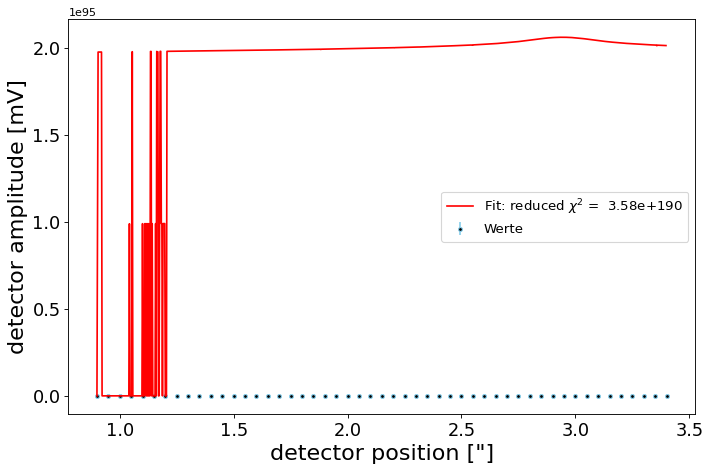

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Amps_B05A_Fit.pdf} 
	\caption{Amps_B05A, Fit} 
 	\label{fig:Amps_B05A, Fit} 
\end{figure}


In [48]:
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())

In [29]:
from scipy.optimize import curve_fit

xdata = Daten.get_x()
ydata = Daten.get_y()

popt, pcov = curve_fit(model_func, xdata, ydata)
popt


C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:54: RuntimeWarning: overflow encountered in exp
  return 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:54: RuntimeWarning: overflow encountered in scalar multiply
  return 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:97: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

array([1.])

In [31]:
pcov

array([[1.00687519e-14]])

C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:54: RuntimeWarning: overflow encountered in exp
  return 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:54: RuntimeWarning: overflow encountered in scalar multiply
  return 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:97: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

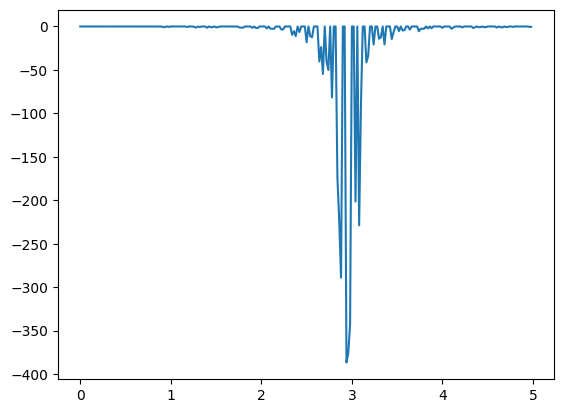

In [30]:
test_array = np.arange(0, 5, 0.02)
plt.plot(test_array, model_func(test_array, 2))

In [32]:
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel, Model, voigt

# import pylandau

# def plot_func(x, mpv=1, eta=1, sigma=1, A=1):
#     return pylandau.langau(x, mpv, eta, sigma, A)

def plot_func(x, sigma = 1, nu = 1, amplitude=1):
    return amplitude/(sigma*np.sqrt(2*math.pi))*np.exp(-1/2*((x-nu)/sigma)**2)


# x, g, g_= symbols("x, g, g_")

# mod = Model(lambdify((x,g), integral_pos)) + Model(lambdify((x,g_), integral_neg))

Daten.set_func(plot_func)
mod = Model(model_func)# Model(model_func_pos) + Model(model_func_neg)

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
g,-inf,None,-inf,inf,True


In [39]:
pars["g"].set(min = 0)
pars["g"].set(max = 3)
pars["g"].set(value = 3)
# pars["g_"].set(min = 0)
# pars["g_"].set(max = 3)

## Parameter Festlegen

In [40]:
# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

In [41]:
param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = IntText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, Save=IntText(value=0), Load=IntText(value=0), **param_widgets)
print()

interactive(children=(IntText(value=0, description='Save'), IntText(value=0, description='Load'), IntText(valu…

In [42]:
result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))

plt.figure(figsize=(8, 6))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')
plt.legend()
plt.ylabel(Daten.get_YName(), fontsize=20)
plt.xlabel(Daten.get_XName(), fontsize=20)
plt.title('Models')

plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))

plt.show()

C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2 * np.pi) * sigma)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:54: RuntimeWarning: overflow encountered in exp
  return 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:86: RuntimeWarning: invalid value encountered in multiply
  return R(b - a) * h_pos(a, g)
C:\Users\tlock\AppData\Local\Temp\ipykernel_3172\3526075977.py:97: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrange

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [ ]:
result

In [37]:
Daten.get_pars()

C:\Users\tlock\AppData\Local\Temp\ipykernel_18912\2553003439.py:1: RuntimeWarning: divide by zero encountered in divide
  weights = 1/np.sqrt(Daten.get_y())


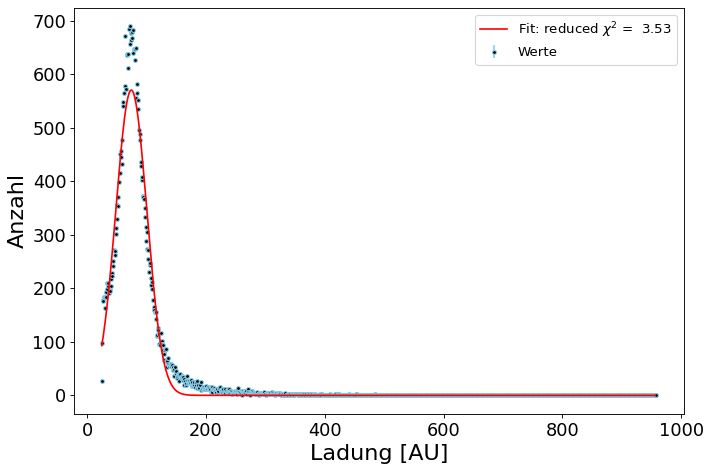

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/A4_V20.h5_charge.txt_Fit.pdf} 
	\caption{A4_V20.h5_charge.txt, Fit} 
 	\label{fig:A4_V20.h5_charge.txt, Fit} 
\end{figure}


In [17]:
weights = 1/np.sqrt(Daten.get_y())
weights[weights == np.inf] = 0
Daten.set_yerr(weights)

result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), weights = weights)
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())